In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

## Load data and matched model output

In [2]:
dfchl=pd.read_excel('/ocean/ksuchy/MOAD/observe/SaanichChlorophyll.xlsx',engine='openpyxl')

In [3]:
dfzoop=pd.read_excel('/ocean/ksuchy/MOAD/observe/SaanichGrowthRates.xlsx',engine='openpyxl')

In [4]:
modSourceDir= '/results2/SalishSea/nowcast-green.201905/'
modver='201905'
Chl_N=1.8 # Chl:N ratio
fname='SaanichChlorophyll.ipynb'
startYMD=(2010,1,1)
endYMD=(2011,12,31)

In [5]:
# Parameters
modSourceDir = "/results2/SalishSea/nowcast-green.201905/"
modver = "201905"
Chl_N = 1.8
fname = "SaanichChlorophyll.ipynb"


In [6]:
start_date = dt.datetime(startYMD[0],startYMD[1],startYMD[2])
end_date = dt.datetime(endYMD[0],endYMD[1],endYMD[2]) #dt.datetime(2019,6,30)

In [7]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [8]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

In [9]:
PATH= modSourceDir

In [10]:
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','microzooplankton':'ptrc_T','mesozooplankton':'ptrc_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'ptrc_T':1,'grid_T':1} #24 for hours averaged 

In [11]:
data=et.matchData(dfchl,filemap,fdict,start_date,end_date,namfmt,PATH,flen,quiet=False,method='vertNet')

In [12]:
data

,dtUTC,Lat,Lon,Z_lower,Z_upper,Total Chl (mg m-3),j,i,mod_diatoms,mod_ciliates,mod_flagellates,mod_microzooplankton,mod_mesozooplankton,k_upper,k_lower
0,2010-03-11,48.59,-123.51,0.0,0.0,0.243490,343,198,0.040448,0.199224,0.429197,0.227070,0.711784,0,0
1,2010-03-11,48.59,-123.51,2.0,0.0,0.291465,343,198,0.040510,0.199172,0.429231,0.227051,0.712285,0,1
2,2010-03-11,48.59,-123.51,8.0,0.0,0.483764,343,198,0.039376,0.191903,0.403705,0.220368,0.692881,0,7
3,2010-03-11,48.59,-123.51,18.0,0.0,0.290795,343,198,0.028671,0.166482,0.340165,0.207580,0.616539,0,17
4,2010-03-18,48.59,-123.51,0.0,0.0,0.910129,343,198,0.081324,0.188550,0.326102,0.228957,0.724507,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2011-08-17,48.59,-123.51,20.0,0.0,0.381356,343,198,0.166858,0.183225,1.052072,0.363879,1.000517,0,18
108,2011-08-18,48.59,-123.51,3.0,0.0,2.800714,343,198,0.034573,0.211816,2.666793,0.449175,1.584530,0,2
109,2011-08-18,48.59,-123.51,0.0,0.0,1.627941,343,198,0.036832,0.215726,2.634916,0.451900,1.566041,0,0
110,2011-08-18,48.59,-123.51,1.0,0.0,1.925235,343,198,0.036832,0.215726,2.634916,0.451900,1.566041,0,0


In [13]:
data.keys()

Index(['dtUTC', 'Lat', 'Lon', 'Z_lower', 'Z_upper', 'Total Chl (mg m-3)', 'j',
       'i', 'mod_diatoms', 'mod_ciliates', 'mod_flagellates',
       'mod_microzooplankton', 'mod_mesozooplankton', 'k_upper', 'k_lower'],
      dtype='object')

In [14]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

In [15]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

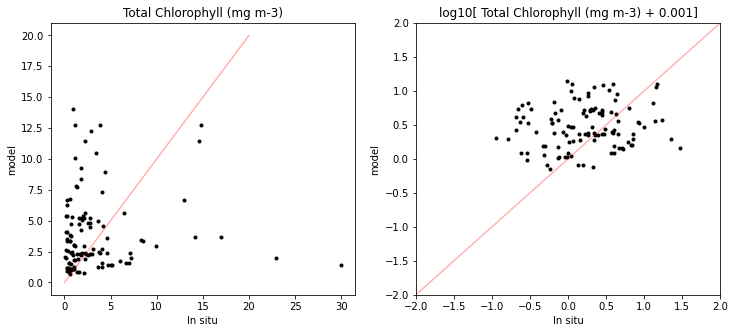

In [16]:
# total chlorophyll comparisons

fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(data['Total Chl (mg m-3)'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
ax[0].set_title('Total Chlorophyll (mg m-3)')
ax[0].set_xlabel('In situ')
ax[0].set_ylabel('model')
ax[0].plot((0,20),(0,20),'r-',alpha=.3)

ax[1].plot(logt(data['Total Chl (mg m-3)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax[1].set_title('log10[ Total Chlorophyll (mg m-3) + 0.001]')
ax[1].set_xlabel('In situ')
ax[1].set_ylabel('model')
ax[1].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[1].set_xlim(-2,2)
ax[1].set_ylim(-2,2);

### By time of year

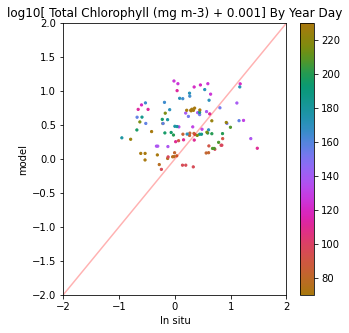

In [17]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['Total Chl (mg m-3)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],s=5,cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (mg m-3) + 0.001] By Year Day')
ax.set_xlabel('In situ')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-2,2)
ax.set_ylim(-2,2);
fig.colorbar(m)

In [18]:
data2=et.matchData(dfzoop,filemap,fdict,start_date,end_date,namfmt,PATH,flen,quiet=False,method='vertNet')

In [19]:
data2

,dtUTC,Lat,Lon,Z_lower,Z_upper,P/B,Production (mg C m-3 d-1),Total Zoop Biomass,Crustacean Biomass,Non Crustacean Biomass,Copepod Biomass,j,i,mod_diatoms,mod_ciliates,mod_flagellates,mod_microzooplankton,mod_mesozooplankton,k_upper,k_lower
0,2010-03-11,48.59,-123.51,100,0,0.07,1.2440,8.290669,3.243590,5.047079,0.520046,343,198,0.005826,0.062270,0.126569,0.077338,0.263825,0,26
1,2010-03-18,48.59,-123.51,100,0,0.03,0.2210,4.060603,2.512094,1.548508,0.264141,343,198,0.005328,0.054736,0.080570,0.069930,0.244276,0,26
2,2010-03-25,48.59,-123.51,100,0,0.19,4.2510,36.644737,30.733623,5.911114,23.101529,343,198,0.076232,0.072212,0.121279,0.089836,0.315205,0,26
3,2010-04-01,48.59,-123.51,100,0,0.12,1.2260,46.617782,40.007711,6.610072,19.809854,343,198,0.075533,0.061035,0.082296,0.101349,0.307562,0,26
4,2010-04-08,48.59,-123.51,100,0,0.09,1.3880,34.579127,25.701994,8.877132,12.247770,343,198,0.065094,0.067745,0.061757,0.114043,0.392400,0,26
5,2010-04-22,48.59,-123.51,100,0,0.17,9.9750,262.540128,131.746410,130.793718,82.864384,343,198,0.425403,0.061022,0.076136,0.179260,0.556790,0,26
6,2010-04-30,48.59,-123.51,100,0,0.33,15.6050,51.105538,44.424950,6.680588,23.486172,343,198,0.481471,0.062651,0.053549,0.214730,0.696853,0,26
7,2010-05-10,48.59,-123.51,100,0,0.01,0.0500,95.222814,77.358661,17.864153,47.502435,343,198,0.378584,0.064544,0.054282,0.334101,0.578348,0,26
8,2010-05-17,48.59,-123.51,100,0,0.04,0.0500,3588.541938,3365.892137,222.649801,369.704100,343,198,0.111863,0.080993,0.032333,0.228445,0.511851,0,26
9,2010-06-02,48.59,-123.51,100,0,0.42,11.7550,1165.543557,930.559191,234.984366,121.311437,343,198,0.197229,0.057556,0.055628,0.151322,0.721399,0,26


In [20]:
data2.keys()

Index(['dtUTC', 'Lat', 'Lon', 'Z_lower', 'Z_upper', 'P/B',
       'Production (mg C m-3 d-1)', 'Total Zoop Biomass', 'Crustacean Biomass',
       'Non Crustacean Biomass', 'Copepod Biomass', 'j', 'i', 'mod_diatoms',
       'mod_ciliates', 'mod_flagellates', 'mod_microzooplankton',
       'mod_mesozooplankton', 'k_upper', 'k_lower'],
      dtype='object')

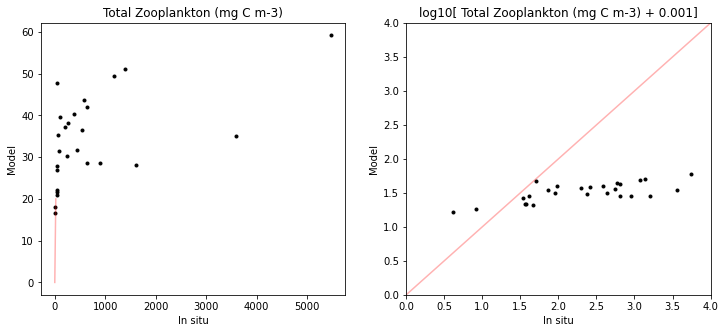

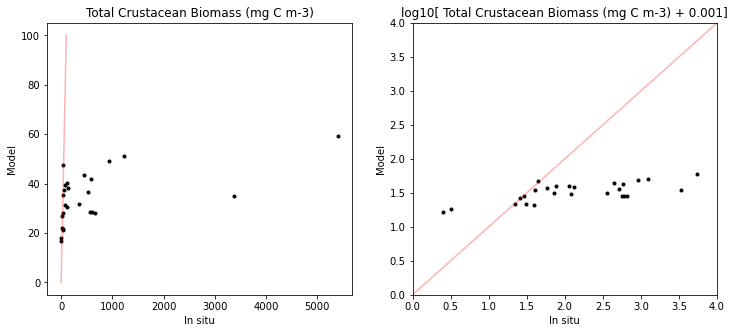

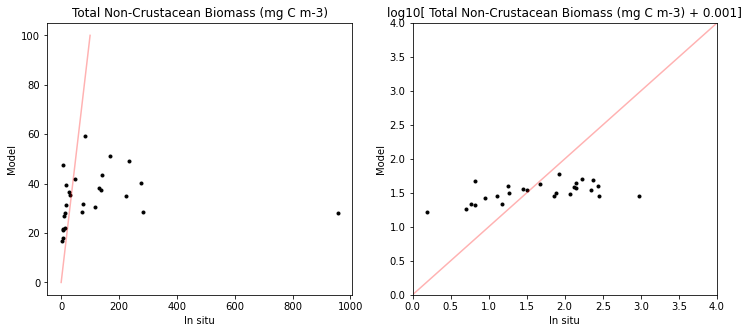

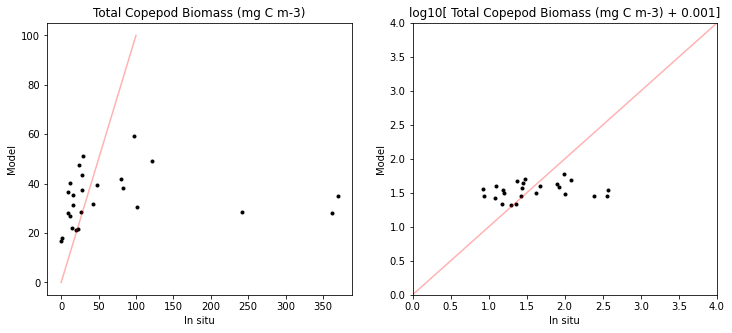

In [23]:
# total zooplankton comparisons

fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(data2['Total Zoop Biomass'],(data2['mod_mesozooplankton']*5.7*12),'k.')
ax[0].set_title('Total Zooplankton (mg C m-3)')
ax[0].set_xlabel('In situ')
ax[0].set_ylabel('Model')
ax[0].plot((0,20),(0,20),'r-',alpha=.3)


ax[1].plot(logt(data2['Total Zoop Biomass']),logt((data2['mod_mesozooplankton']*5.7*12)),'k.')
ax[1].set_title('log10[ Total Zooplankton (mg C m-3) + 0.001]')
ax[1].set_xlabel('In situ')
ax[1].set_ylabel('Model')
ax[1].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[1].set_xlim(0,4)
ax[1].set_ylim(0,4);


fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(data2['Crustacean Biomass'],(data2['mod_mesozooplankton']*5.7*12),'k.')
ax[0].set_title('Total Crustacean Biomass (mg C m-3)')
ax[0].set_xlabel('In situ')
ax[0].set_ylabel('Model')
ax[0].plot((0,100),(0,100),'r-',alpha=.3)


ax[1].plot(logt(data2['Crustacean Biomass']),logt((data2['mod_mesozooplankton']*5.7*12)),'k.')
ax[1].set_title('log10[ Total Crustacean Biomass (mg C m-3) + 0.001]')
ax[1].set_xlabel('In situ')
ax[1].set_ylabel('Model')
ax[1].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[1].set_xlim(0,4)
ax[1].set_ylim(0,4);

fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(data2['Non Crustacean Biomass'],(data2['mod_mesozooplankton']*5.7*12),'k.')
ax[0].set_title('Total Non-Crustacean Biomass (mg C m-3)')
ax[0].set_xlabel('In situ')
ax[0].set_ylabel('Model')
ax[0].plot((0,100),(0,100),'r-',alpha=.3)


ax[1].plot(logt(data2['Non Crustacean Biomass']),logt((data2['mod_mesozooplankton']*5.7*12)),'k.')
ax[1].set_title('log10[ Total Non-Crustacean Biomass (mg C m-3) + 0.001]')
ax[1].set_xlabel('In situ')
ax[1].set_ylabel('Model')
ax[1].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[1].set_xlim(0,4)
ax[1].set_ylim(0,4);

fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(data2['Copepod Biomass'],(data2['mod_mesozooplankton']*5.7*12),'k.')
ax[0].set_title('Total Copepod Biomass (mg C m-3)')
ax[0].set_xlabel('In situ')
ax[0].set_ylabel('Model')
ax[0].plot((0,100),(0,100),'r-',alpha=.3)


ax[1].plot(logt(data2['Copepod Biomass']),logt((data2['mod_mesozooplankton']*5.7*12)),'k.')
ax[1].set_title('log10[ Total Copepod Biomass (mg C m-3) + 0.001]')
ax[1].set_xlabel('In situ')
ax[1].set_ylabel('Model')
ax[1].plot((-6,5),(-6,5),'r-',alpha=.3)
ax[1].set_xlim(0,4)
ax[1].set_ylim(0,4);